In [2]:
import os
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
client_id = SPOTIPY_CLIENT_ID ='bb7c475418484e7784d9cd25b5f9f52c'
client_secret = SPOTIPY_CLIENT_SECRET='b0da0baeeab1499884912aea11f4ca58'
redirect_uri =SPOTIPY_REDIRECT_URI='https://localhost:8080/callback/'


os.environ["SPOTIPY_CLIENT_ID"] = "bb7c475418484e7784d9cd25b5f9f52c"
os.environ["SPOTIPY_CLIENT_SECRET"] = "b0da0baeeab1499884912aea11f4ca58"
os.environ["SPOTIPY_REDIRECT_URI"] = "https://localhost:8080/callback/"

scope = "playlist-modify-public playlist-modify-private user-modify-playback-state user-top-read"
scope +=            " user-modify-playback-state user-read-playback-state user-library-read user-library-modify"
username = 'tonyryanworldwide'

        
token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)        
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope,username=username))


In [3]:
import pandas as pd
from pandas import DataFrame
total = sp.current_user_saved_tracks()['total']
offset = 50
savedtracks = sp.current_user_saved_tracks(limit = 50)['items']
while offset < total:
    
    savedtracks2 =sp.current_user_saved_tracks(limit = 50,offset=offset)['items']
    for track in savedtracks2:
        savedtracks.append(track)
    offset += 50

    
trackinfo ={}   
for trackex in savedtracks:
    id = trackex['track']['id']
    name = trackex['track']['name']
    artistid = trackex['track']['artists'][0]['id']
    seconds = trackex['track']['duration_ms']/1000
    trackinfo[trackex['track']['id']] = {"artist" : artistid,"name":name,"seconds":seconds}
#     trackinfo['loudness'] = sp.audio_features(id)[0]['loudness']
    
trackdf = pd.DataFrame.from_dict(trackinfo,orient = "index").reset_index()
artists = trackdf.artist.unique()
trackdf.columns = ['trackid','artistid','trackname','tracklength_sec']

artistinfo = []
i = 0
while i < len(artists) - 50:
    x=sp.artists(artists[i:i+50])['artists']
    artistinfo.append(x)
    i+=50
artistfinal ={}
for i in artistinfo:
    for j in i:   
        id = j['id']
        name = j['name']
        if len(j['genres']) > 0:
            genre = j['genres']#[0]
        else:
            genre = ''
        artistfinal[id] = {"name":name,"genre": genre}          
artistdf = pd.DataFrame.from_dict(artistfinal,orient = "index").reset_index()
artistdf = artistdf.reset_index()[['index','name','genre']]
artistdf.columns = ['artistid','artistname','genre']
artistdf =artistdf[artistdf['genre']!=''].reset_index()[['artistid','artistname','genre']]




In [4]:
tracks = list(trackinfo.keys())
j = 0
audfeat = []
while j < len(tracks):
    audfeat = audfeat +  sp.audio_features(tracks[j:j+100])
    j += 100



In [5]:
dfAudio = pd.DataFrame(audfeat)
dfAudio.drop(columns=['key','mode','type','uri','track_href','analysis_url'],inplace = True)
audio_features = dfAudio[dfAudio.columns[0:8]]
audio_labels = dfAudio['id'].values



In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA




# Normalize the numeric features so they're on the same scale
audio_features[dfAudio.columns[0:8]] = MinMaxScaler().fit_transform(audio_features[dfAudio.columns[0:8]])



# # Get two principal components
pca = PCA(n_components=2).fit(audio_features.values)
audio_2d = pca.transform(audio_features.values)
audio_2d[0:10]


pca = PCA(n_components=3).fit(audio_features.values)
audio_3d = pca.transform(audio_features.values)
audio_3d[0:10]

<ipython-input-6-bc317cb5150e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  audio_features[dfAudio.columns[0:8]] = MinMaxScaler().fit_transform(audio_features[dfAudio.columns[0:8]])
C:\Users\aryan\Anaconda3\envs\azureml\lib\site-packages\pandas\core\frame.py:3072: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\aryan\Anaconda3\envs\azureml\lib\site-packages\pandas\core\frame.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats 

array([[-0.06438293,  0.17051664, -0.25828089],
       [-0.0442723 , -0.20931118,  0.0399315 ],
       [ 0.40583208,  0.03494571, -0.18532662],
       [ 0.05269946, -0.10462552, -0.05296612],
       [-0.28851694,  0.18275121, -0.16090264],
       [-0.20086379,  0.31245392, -0.3655866 ],
       [-0.11266625,  0.25516777, -0.27619222],
       [-0.19347616,  0.09401372, -0.12529008],
       [ 0.26551566, -0.43042244,  0.08612075],
       [-0.28860842,  0.13170867, -0.15715465]])

C:\Users\aryan\AppData\Roaming\Python\Python38\site-packages\matplotlib\collections.py:1003: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


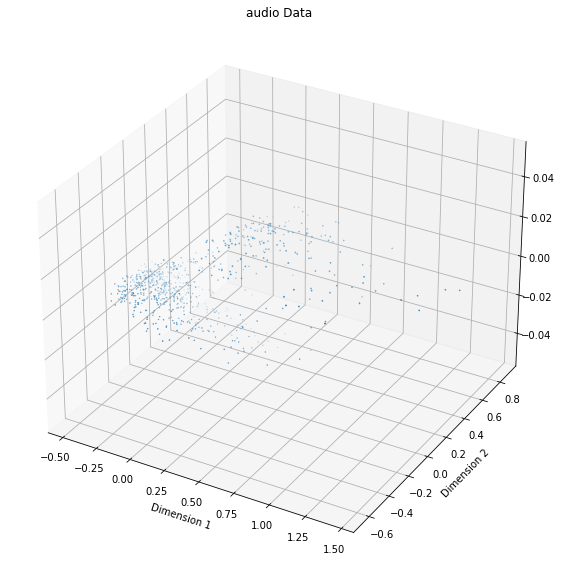

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

fig = plt.figure()
ax = plt.axes(projection='3d')
fig.set_size_inches(10, 10)

plt.scatter(audio_3d[:,0],audio_3d[:,1],audio_3d[:,2])
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
# plt.zlabel('Dimension 3')
plt.title('audio Data')

plt.show()

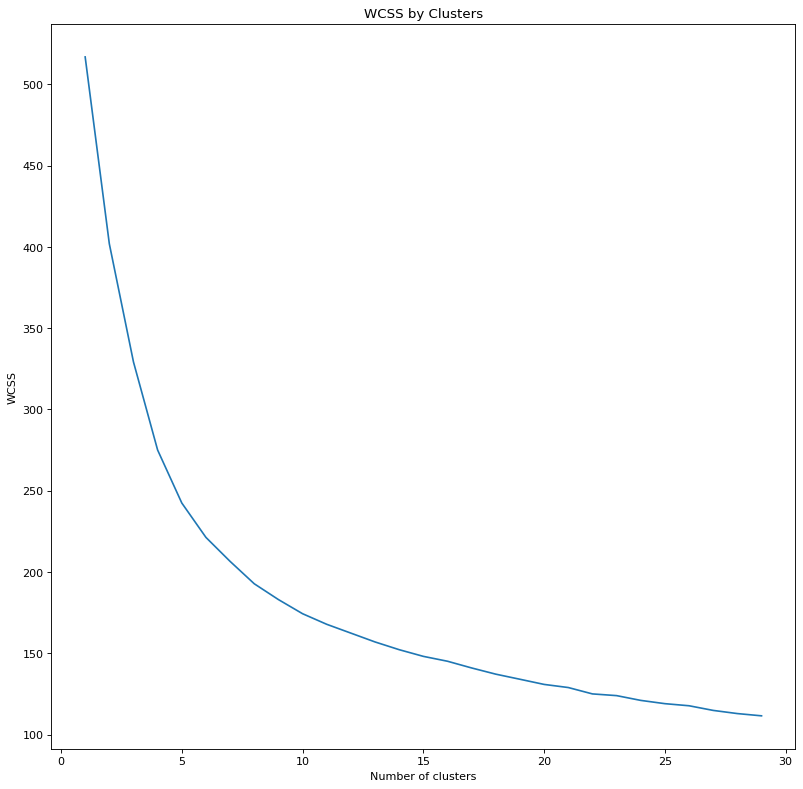

In [17]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from matplotlib.pyplot import figure
%matplotlib inline

# Create 10 models with 1 to x clusters
wcss = []
numclustertest = 30
for i in range(1, numclustertest):
    kmeans = KMeans(n_clusters = i)
    # Fit the Iris data points
    kmeans.fit(audio_features.values)
    # Get the WCSS (inertia) value
    wcss.append(kmeans.inertia_)
figure(figsize=(12, 12), dpi=80)  
#Plot the WCSS values onto a line graph
plt.plot(range(1, 30), wcss)
plt.title('WCSS by Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

In [20]:
audio_features.values


array([[3.43967648e-01, 7.69473429e-01, 8.53806157e-01, ...,
        1.39839034e-04, 3.08047155e-01, 2.91096254e-01],
       [9.48326219e-01, 6.94653401e-01, 7.24669179e-01, ...,
        5.17102616e-03, 8.66222450e-02, 4.19505465e-01],
       [4.84385531e-01, 3.09431368e-01, 7.78810971e-01, ...,
        5.52313883e-05, 9.48231676e-02, 1.43584846e-01],
       ...,
       [5.87733094e-01, 7.60373696e-01, 7.68796941e-01, ...,
        1.29778672e-05, 3.31624808e-01, 6.71017723e-01],
       [6.23680072e-01, 5.53101998e-01, 7.87999670e-01, ...,
        1.31790744e-03, 2.81394157e-01, 2.92157487e-01],
       [6.62997079e-01, 3.85262477e-01, 6.10965914e-01, ...,
        0.00000000e+00, 9.58482829e-02, 5.73384273e-01]])

In [22]:
def getNumClusters(audio_features):
    numclustertest = 30
    wcss = []
    for i in range(1, numclustertest):
        kmeans = KMeans(n_clusters = i)
        # Fit the Iris data points
        kmeans.fit(audio_features.values)
        # Get the WCSS (inertia) value
        wcss.append(kmeans.inertia_)
    for i in range(2,numclustertest):
        diflast = wcss[i-1] - wcss[i-2]
        dif = wcss[i] - wcss[i-1]
        if dif < diflast:
            n_clusters = i
            break
    return n_clusters
n_clusters

12

In [18]:
for i in range(2,numclustertest):
    diflast = wcss[i-1] - wcss[i-2]
    dif = wcss[i] - wcss[i-1]
    if dif < diflast:
        n_clusters = i
        break

        
        
n_clusters

12

In [ ]:
from sklearn.cluster import KMeans
# Create a model based on n centroids
model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=50, max_iter=300,verbose= True,random_state = 56)

# Fit to the iris data and predict the cluster assignments for each data point
km_clusters = model.fit_predict(audio_features.values)
# View the cluster assignments
km_clusters

In [ ]:
import itertools
from matplotlib.pyplot import figure
col_dic_base = {0:'blue',1:'green',2:'orange',3:'red',4:'yellow',
                5:'black',6:'teal',7: 'brown', 8: 'purple',9: 'azure',
                10:'slateblue',11:'green',12:'indianred',13:'orange',14:'yellow',
                15:'black',16:'teal',17: 'brown', 18: 'purple',19: 'azure',
               20:'thistle',21:'lightcyan'}
mrk_dic_base = {0:'*',1:'x',2:'+',3:'p',4:'h',
                5:'d',6:'<',7:'>',8:'*',9:'v',
                10:'o',11:'.',12:'^',13:'s',14:'$&$',
                15:'$@$',16:'$G$',17:'$4$',18:'$?$',19:'$19$',
               20:'$P$',21:'$H$'}

def plot_clusters(samples, clusters):
    col_dic = dict(itertools.islice(col_dic_base.items(), n_clusters))
    mrk_dic = dict(itertools.islice(mrk_dic_base.items(), n_clusters))
    colors = [col_dic[x] for x in clusters]
    markers = [mrk_dic[x] for x in clusters]
    for sample in range(len(clusters)):
        plt.scatter(samples[sample][0], samples[sample][1], color = colors[sample], marker=markers[sample], s=100)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Assignments')    
    plt.show()
    
    
figure(figsize=(20, 20), dpi=80)
plot_clusters(audio_2d, km_clusters)

## Delete Old Clusters

In [ ]:
#Delete
lenplaylists = 1
offset = 0
while lenplaylists > 0:
    playlists = sp.user_playlists(username,offset=offset)['items']
    lenplaylists = len(playlists)
    
    for playlist in playlists:
        name= playlist['name'] 
        id = playlist['uri'][-22:]    
        if name[0:7] =='Cluster':
            print('deleting{0} id {1}'.format(name,id))
            sp.user_playlist_unfollow(user=username, playlist_id = id)
    offset += 20

In [ ]:
classifyer_dict = {}
for x in range(0,len(audio_labels)):
    classifyer_dict[audio_labels[x]] = km_clusters[x]
classifyer_dict

In [ ]:
for cluster in range(0,n_clusters):
    name = 'Cluster Number ' + str(cluster)
    id = sp.user_playlist_create(user=username,name=name)['id']
    globals()[f"cluster_{cluster}"] = []
    for (key, value) in classifyer_dict.items():
#         print(key,value)
        if value == cluster:
#             print('yeah')
            globals()[f"cluster_{cluster}"].append(key)
    tracks = globals()[f"cluster_{cluster}"]
    lengthtracks = len(tracks)
    x= 0
    if lengthtracks <= 100:
        y = lengthtracks
        print("x:{0} y:{1}".format(x,y))
        sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
    else:
        y = 100
        print("1st else: x{} y{}".format(x,y))
        sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
        iteration = 1
        while y >0:
            x = x +100
            print(x,lengthtracks, 'Length of x and tracks')
            if lengthtracks <= x  + 100:
                y = lengthtracks   
                print("inif: x{} y{}".format(x,y))
                sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
                y = 0
            else:
                y = y + 100
                print("else x:{} y:{}".format(x,y))
                sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
            iteration += 1

In [ ]:
column_names = ["artistid", "artistname", "genre"]

finalartist = pd.DataFrame(columns = column_names)

for i in range(0, len(artistdf)):
    df = artistdf[i:i+1][['artistid','artistname']]
#     print(i)
#     print(df)
    genres = artistdf[i:i+1]['genre'][i]
    gf= DataFrame(genres,columns=['genre'])
    product = (
    df.assign(key=1)
    .merge(gf.assign(key=1), on="key")
    .drop("key", axis=1)
    )
    finalartist = finalartist.append(product)
    

In [ ]:
finaltrackinfo = trackdf.merge(finalartist, left_on = 'artistid', right_on = 'artistid', how = 'inner' )
finaltrackinfo['cum_sec'] = finaltrackinfo.groupby('genre')['tracklength_sec'].apply(lambda x: x.cumsum())
finaltrackinfo.to_csv('finaltrackinfo.csv')

In [ ]:
genres = finaltrackinfo.groupby('genre').count().reset_index()[['genre','artistid']]
genres.columns=['genre','count']
genres = genres[(genres['count'] >= 25) & (genres['genre']!= '')].sort_values(by ='count', ascending = False)
genrelist = genres['genre'].tolist()
finaltrackinfo = finaltrackinfo[finaltrackinfo['genre'].isin(genres['genre'])]

In [ ]:
def genrefilter(df,gen,sec_lim = 36000):
    dfin = df['trackid'][(df['genre'] == gen) & (df['cum_sec'] <= sec_lim)]
    return dfin.tolist()#[0:100]



In [ ]:
for gen in genrelist:
    id = sp.user_playlist_create(user=username,name =gen)['id']
    tracks = genrefilter(finaltrackinfo,gen)
#     sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks,position = 0)
    lengthtracks = len(tracks)
    x= 0
    if lengthtracks <= 100:
        y = lengthtracks
        print("x:{0} y:{1}".format(x,y))
        sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
    else:
        y = 100
        print("1st else: x{} y{}".format(x,y))
        sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
        iteration = 1
        while y >0:
            x = x +100
            if lengthtracks < x  + 100:
                y = lengthtracks   
                print("inif: x{} y{}".format(x,y))
                sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
                y = 0
            else:
                y = y + 100
                print("else x:{} y:{}".format(x,y))
                sp.user_playlist_add_tracks(user = username, playlist_id =id,tracks = tracks[x:y],position = 0)
            iteration += 1

In [ ]:
ignorelist = ['Your Top Songs 2018','Best Kings']

def playplaylist():
    currentsong = sp.current_playback()
    if currentsong is None:
        print('Nothing''s playing homie')
        return
    currenturi = currentsong['item']['external_urls']['spotify']
    currentsongid = currentsong['item']['id']
    progress_ms = currentsong['progress_ms']
    playlists = sp.user_playlists(username,offset=0)['items']
    playlistbase = (sp.user_playlists(username,offset=50)['items'])
    for pl in playlistbase:
        playlists.append(pl)
    playlistids =[]
    for playlist in playlists:
        playlistid = playlist['id']
        playlistname = playlist['name']
        context_uri = playlist['external_urls']['spotify']
        playlistids.append(playlistid)
        playlist_tracks = sp.playlist_tracks(playlistid)['items']
        for i in range(0,len(playlist_tracks)):
            trackid = playlist_tracks[i]['track']['id']            
            if (trackid == currentsongid):
                print(trackid)
                if playlistname not in ignorelist:
                    print("trackid: {0} context_uri: {1} playlistname: {2} playlistid: {3}".format(trackid,context_uri,playlistname,playlistid))
                    sp.start_playback(context_uri = context_uri,offset ={'position':i},position_ms=progress_ms)
                    return                
    print('No Playlists')
    
playplaylist()


In [ ]:
currentsong = sp.current_playback()
print(currentsong)

In [ ]:
currentsong = sp.current_playback()
currenturi = currentsong['item']['external_urls']['spotify']
trackid = '3BjNm8Zy8rnCSRquLOXSdu'
playlist_tracks = sp.playlist_tracks('3OQAp1crJ3w7ypjdsvUtFS')['items']
for i in range (0,len(playlist_tracks)):
    track = playlist_tracks[i]['track']['id']
    if track == trackid:
        print(i)
        sp.start_playback(context_uri = contexturi,offset={'position':i})

In [ ]:
currentsong = sp.current_playback()
currentsong['progress_ms']

In [ ]:


if (playlistname not in ignorelist):
    print('hi')

In [ ]:
# sp.start_playback(context_uri = 'https://open.spotify.com/playlist/3BJ5LAJY99NDCFkxqJtnwo')

playlists[0]['external_urls']['spotify']

In [ ]:
currentsongid

# currentsong = sp.current_playback()
# currentson(g['item']['id']

# playlistids[0]

# tracks = sp.playlist_tracks(playlistids[0])['items']
# tracks[0]['track']['id']

## For Debugging Delete CreatedPlaylists

In [ ]:
# playlists =sp.current_user_playlists(offset=100)['items']
playlists = sp.user_playlists(username,offset=50)['items']
for playlist in playlists:
    name= playlist['name']

    
    id = playlist['uri'][-22:]
    
    if name in genrelist:
        print('deleting{0} id {1}'.format(name,id))
        sp.user_playlist_unfollow(user=username, playlist_id = id)

In [ ]:
offset =0
playlistlength =50
while(playlistlength == 50):   
    playlists = sp.user_playlists(username,offset=offset)['items']
    playlistlength = len(playlists)
    print('')
    print("playlistlength {0}".format(playlistlength))
    print('')
    for playlist in playlists:
        name= playlist['name']
#         print(name)
        id = playlist['uri'][-22:]
    
        if name in genrelist:
#             print('')
            print('deleting{0} id {1}'.format(name,id))
            sp.user_playlist_unfollow(user=username, playlist_id = id)
    offset += 50
    

In [ ]:
playlists = sp.user_playlists(username,offset=0)['items']
len(playlists)